## Preprocessing and cleaning 

In this notebook I explore the dataset and pre process it in order to generate a new dataset. In short the procedure contains
1) The creation of new columns  'Year', 'Month', 'Day', 'Hour', 'Minute', 'Currency Code',	'Rate',	'Amount Paid USD',	'Amount Received USD'
2) Standardise amount in different currencies to USD
 

In [2]:
import pandas as pd
import requests 

In [2]:
 df= pd.read_csv('/Users/ludwingmoncadabellorin/code/Malvinrud/aml_detector/raw_data/HI-Small_Trans.csv')

In [3]:
# Get number of rows
num_rows = len(df)
print("Number of rows: ", num_rows)

Number of rows:  5078345


In [4]:
# Column names and data type
df.dtypes

Timestamp              object
From Bank               int64
Account                object
To Bank                 int64
Account.1              object
Amount Received       float64
Receiving Currency     object
Amount Paid           float64
Payment Currency       object
Payment Format         object
Is Laundering           int64
dtype: object

In [5]:
#How many unique accounts there are
unique_count = df['Account'].nunique()
print('Unique count of Account: ', unique_count)


Unique count of Account:  496995


In [6]:
# Get the distribution of Is Laundering 
laundering_counts = df['Is Laundering'].value_counts(normalize=True)
print(laundering_counts)

0    0.998981
1    0.001019
Name: Is Laundering, dtype: float64


In [7]:
# Identify Unique Currencies
unique_currencies = df['Payment Currency'].unique()
print(unique_currencies)

['US Dollar' 'Bitcoin' 'Euro' 'Australian Dollar' 'Yuan' 'Rupee' 'Yen'
 'Mexican Peso' 'UK Pound' 'Ruble' 'Canadian Dollar' 'Swiss Franc'
 'Brazil Real' 'Saudi Riyal' 'Shekel']


In [8]:
# Get the distribution the percentual distribution of flagged transactions by currency 

# Group by payment_currency and Is_Laundering, count the number of rows
distribution = df.groupby(['Payment Currency', 'Is Laundering']).size().reset_index(name='Count')

# Calculate the total counts per currency and name it
total_counts = df.groupby('Payment Currency').size()
total_counts.name = 'Count_total'

# Join the total_counts to the distribution dataframe
distribution = distribution.set_index('Payment Currency').join(total_counts)

# Calculate the percentage
distribution['Percent'] = distribution['Count'] / distribution['Count_total'] * 100

# Reset the index
distribution.reset_index(inplace=True)
print(distribution)

     Payment Currency  Is Laundering    Count  Count_total    Percent
0   Australian Dollar              0   136642       136769  99.907143
1   Australian Dollar              1      127       136769   0.092857
2             Bitcoin              0   146010       146066  99.961661
3             Bitcoin              1       56       146066   0.038339
4         Brazil Real              0    70646        70703  99.919381
5         Brazil Real              1       57        70703   0.080619
6     Canadian Dollar              0   139914       140042  99.908599
7     Canadian Dollar              1      128       140042   0.091401
8                Euro              0  1166925      1168297  99.882564
9                Euro              1     1372      1168297   0.117436
10       Mexican Peso              0   110067       110159  99.916484
11       Mexican Peso              1       92       110159   0.083516
12              Ruble              0   155045       155178  99.914292
13              Rubl

In [9]:
# Convert Timestamp into datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Create new columns for year, month, day, hour and minute
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute


In [10]:
# Let's inspect the dataframe
df.head()

Timestamp  From Bank    Account  To Bank  Account.1  \
0 2022-09-01 00:20:00         10  8000EBD30       10  8000EBD30   
1 2022-09-01 00:20:00       3208  8000F4580        1  8000F5340   
2 2022-09-01 00:00:00       3209  8000F4670     3209  8000F4670   
3 2022-09-01 00:02:00         12  8000F5030       12  8000F5030   
4 2022-09-01 00:06:00         10  8000F5200       10  8000F5200   

   Amount Received Receiving Currency  Amount Paid Payment Currency  \
0          3697.34          US Dollar      3697.34        US Dollar   
1             0.01          US Dollar         0.01        US Dollar   
2         14675.57          US Dollar     14675.57        US Dollar   
3          2806.97          US Dollar      2806.97        US Dollar   
4         36682.97          US Dollar     36682.97        US Dollar   

  Payment Format  Is Laundering  Year  Month  Day  Hour  Minute  
0   Reinvestment              0  2022      9    1     0      20  
1         Cheque              0  2022      9    1     0      20  
2   Reinvestment              0  2022      9    1     0       0  
3   Reinvestment              0  2022      9    1     0       2  
4   Reinvestment              0  2022      9    1     0       6

In [11]:
# Now let's standardise the Amounts to US Dollar 

# First let' create a dictionary to map full currency names to their  ISO codes
currency_codes = {
    'Australian Dollar': 'AUD',
    'Bitcoin': 'BTC',
    'Brazil Real': 'BRL',
    'Canadian Dollar': 'CAD',
    'Euro': 'EUR',
    'Mexican Peso': 'MXN',
    'Ruble': 'RUB',
    'Rupee': 'INR',
    'Saudi Riyal': 'SAR',
    'Shekel': 'ILS',
    'Swiss Franc': 'CHF',
    'UK Pound': 'GBP',
    'Yen': 'JPY',
    'Yuan': 'CNY',
    'US Dollar': 'USD'
}

# Replace the full currency names with their codes 
df['Currency Code'] = df['Payment Currency'].replace(currency_codes)


In [14]:
# Get the exchange rate for all the currencies by connecting to Exchange Rate Data API

# Exchange rate data api key
api_key = "wdiQOxfDckJMZr70O1Brmvlh56iJEfE7"

# Arbitrary date to fetch the exchange rates
date = "2022-09-30"

# The list of currency codes to fetch the exchange rates
currency_codes = ["GBP", "EUR", "AUD", "BTC", "BRL", "CAD", "MXN", "RUB", "INR", "SAR", "ILS", "CHF", "JPY", "CNY"]

# URL
url = f"https://api.apilayer.com/exchangerates_data/{date}?symbols={','.join(currency_codes)}&base=USD"

# Define the headers
headers = {
  "apikey": api_key
}

# Send a GET request to the API
response = requests.get(url, headers=headers)

# Convert the response to JSON
data = response.json()

# Create a DataFrame from the rates
df_rates = pd.DataFrame(data['rates'].items(), columns=['Currency Code', 'Rate'])

# Display the DataFrame
print(df_rates)


   Currency Code        Rate
0            GBP    0.896861
1            EUR    1.019910
2            AUD    1.561524
3            BTC    0.000051
4            BRL    5.412471
5            CAD    1.383270
6            MXN   20.146150
7            RUB   60.203690
8            INR   81.638404
9            SAR    3.756801
10           ILS    3.558540
11           CHF    0.987171
12           JPY  144.739040
13           CNY    7.116041


In [15]:
# Merge df with df_rates on 'Currency Code', preserving all rows from df and filling in NaN for missing match
df = df.merge(df_rates, on='Currency Code', how='left')

# Wherever the rate is NaN, that means the currency was USD. We can fill those with 1.
df['Rate'] = df['Rate'].fillna(1)


In [16]:
# Compute 'Amount Paid USD' and 'Amount Received USD'
df['Amount Paid USD'] = df['Amount Paid'] * df['Rate']
df['Amount Received USD'] = df['Amount Received'] * df['Rate']

In [17]:
df.head()

Timestamp  From Bank    Account  To Bank  Account.1  \
0 2022-09-01 00:20:00         10  8000EBD30       10  8000EBD30   
1 2022-09-01 00:20:00       3208  8000F4580        1  8000F5340   
2 2022-09-01 00:00:00       3209  8000F4670     3209  8000F4670   
3 2022-09-01 00:02:00         12  8000F5030       12  8000F5030   
4 2022-09-01 00:06:00         10  8000F5200       10  8000F5200   

   Amount Received Receiving Currency  Amount Paid Payment Currency  \
0          3697.34          US Dollar      3697.34        US Dollar   
1             0.01          US Dollar         0.01        US Dollar   
2         14675.57          US Dollar     14675.57        US Dollar   
3          2806.97          US Dollar      2806.97        US Dollar   
4         36682.97          US Dollar     36682.97        US Dollar   

  Payment Format  Is Laundering  Year  Month  Day  Hour  Minute Currency Code  \
0   Reinvestment              0  2022      9    1     0      20           USD   
1         Cheque              0  2022      9    1     0      20           USD   
2   Reinvestment              0  2022      9    1     0       0           USD   
3   Reinvestment              0  2022      9    1     0       2           USD   
4   Reinvestment              0  2022      9    1     0       6           USD   

   Rate  Amount Paid USD  Amount Received USD  
0   1.0          3697.34              3697.34  
1   1.0             0.01                 0.01  
2   1.0         14675.57             14675.57  
3   1.0          2806.97              2806.97  
4   1.0         36682.97             36682.97

In [130]:
df.to_csv('new_hi_small_trans.csv', index=False)


## Load data to create graph 

In [3]:
df= pd.read_csv('/Users/ludwingmoncadabellorin/code/Malvinrud/aml_detector/raw_data/new_hi_small_trans.csv')

In [4]:
sample_df = df.sample(n=200000)

In [5]:
df=sample_df

In [6]:
#! pip install networkx
import networkx as nx
G = nx.MultiGraph()

df["Account"].unique()

In [7]:
# Add nodes to the graph for each unique card_id, merchant_name
G.add_nodes_from(df["Account"].unique(), type='Account')
G.add_nodes_from(df["Account.1"].unique(), type='Account.1')

In [8]:
for _, row in df.iterrows():
    # Create a variable for each properties for each edge
    
        year = row["Year"],
        month = row["Month"],
        day = row["Day"],
        hour = row["Hour"],
        minute =row["Minute"],
        amount_paid = row["Amount Paid USD"],
        currency_code =  row["Currency Code"],
        payment_format = row["Payment Format"]
    
 
        G.add_edge(row['Account'], row['Account.1'], year = year , month = month , day = day ,
              hour = hour , minute = minute , amount_paid = amount_paid , currency_code = currency_code ,
              payment_format = payment_format)
  

In [9]:
# Get the number of nodes and edges in the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Print the number of nodes and edges
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

Number of nodes: 179592
Number of edges: 200000


In [175]:
# Convert the graph to an adjacency matrix
adj_matrix = nx.adjacency_matrix(G).todense()

/var/folders/mv/g5qy0k9135b9v78lncpfcdqm0000gp/T/ipykernel_84990/1408587376.py:2: FutureWarning:

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.



In [88]:
adj_matrix.shape

(1801, 1801)

In [176]:
# Get a small sample of the nodes in the graph
sample_nodes = list(G.nodes())[:10]

# Retrieve the properties of the sample nodes
node_properties = nx.get_node_attributes(G, 'type')

# Print the properties of the sample nodes
for node in sample_nodes:
    print(f"Node: {node}, Properties: {node_properties[node]}")

Node: 802442D20, Properties: Account
Node: 809A04CE0, Properties: Account
Node: 809B976B0, Properties: Account
Node: 801168AF0, Properties: Account.1
Node: 804A98E00, Properties: Account
Node: 8137529A1, Properties: Account
Node: 801C0E8C0, Properties: Account
Node: 80DA1AC20, Properties: Account
Node: 801364C90, Properties: Account
Node: 8076B8780, Properties: Account


In [177]:
sample_size = 5
for i, edge in enumerate(G.edges()):
    print(G.get_edge_data(*edge))
    if i >= sample_size - 1:
        break

{0: {'year': (2022,), 'month': (9,), 'day': (1,), 'hour': (0,), 'minute': (17,), 'amount_paid': (4964.17,), 'currency_code': ('USD',), 'payment_format': 'Credit Card'}}
{0: {'year': (2022,), 'month': (9,), 'day': (9,), 'hour': (17,), 'minute': (51,), 'amount_paid': (61.1128686,), 'currency_code': ('CAD',), 'payment_format': 'Cash'}}
{0: {'year': (2022,), 'month': (9,), 'day': (2,), 'hour': (7,), 'minute': (44,), 'amount_paid': (24152.05,), 'currency_code': ('USD',), 'payment_format': 'ACH'}}
{0: {'year': (2022,), 'month': (9,), 'day': (1,), 'hour': (0,), 'minute': (11,), 'amount_paid': (135698.15,), 'currency_code': ('USD',), 'payment_format': 'Reinvestment'}}
{0: {'year': (2022,), 'month': (9,), 'day': (5,), 'hour': (20,), 'minute': (8,), 'amount_paid': (2760803.46173384,), 'currency_code': ('INR',), 'payment_format': 'Cash'}}


## Network Visualisation 

In [142]:
import plotly.graph_objects as go

In [123]:
# Create positions of each node using Networkx's spring layout
pos = nx.spring_layout(G)


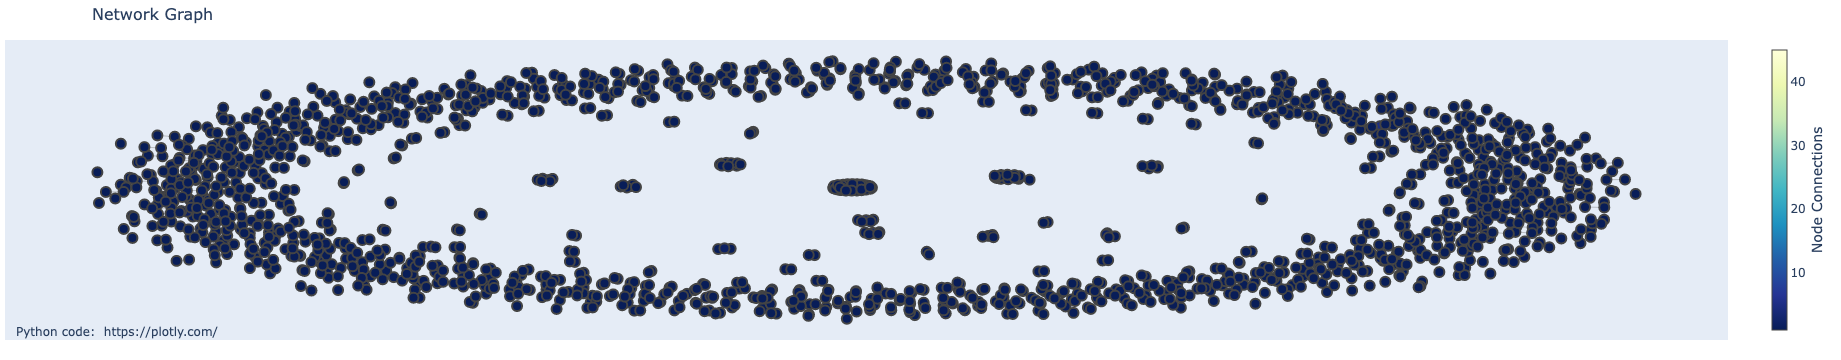

In [124]:
# Create edges in the plotly format
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')


# Create nodes in the plotly format
node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

# Color node points by the number of connections.
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

# Create a plotly figure and add our nodes and edges
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Network Graph',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/'> https://plotly.com/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

### Node Visualisation 

### Median 

In [100]:
# Iterate over the edges in the graph
for node1, node2, edge_data in G.edges(data=True):
    # Append the transaction amount for each node involved in the transaction
    transaction_amounts[node1].append(edge_data['amount_paid'][0])
    transaction_amounts[node2].append(edge_data['amount_paid'][0])
# Now compute the median transaction amount per node
mean_transaction_amounts = {node: np.median(amounts) for node, amounts in transaction_amounts.items()}



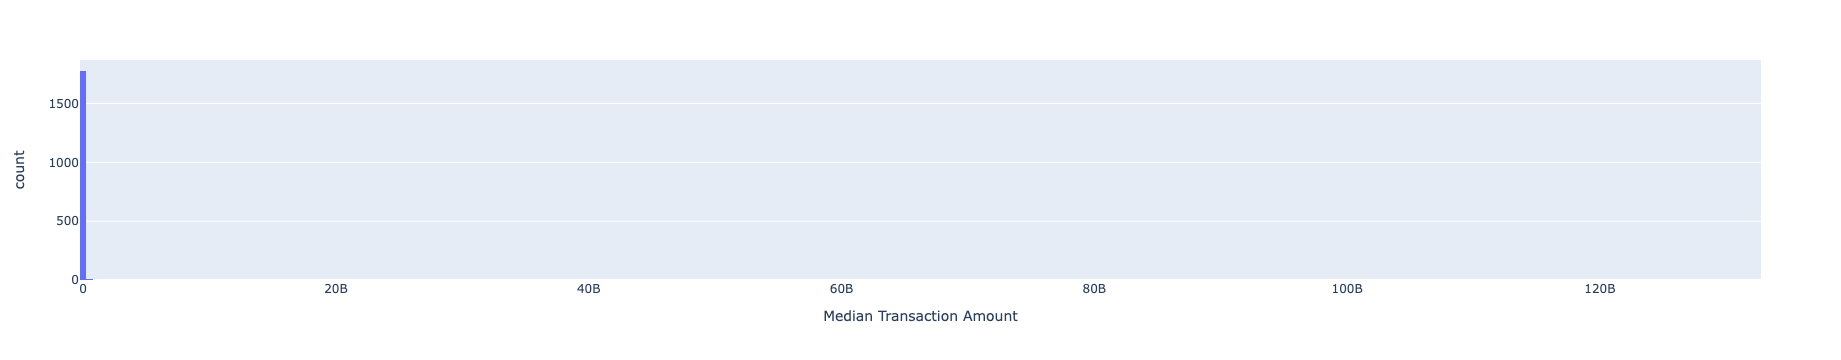

In [101]:
import plotly.express as px
import pandas as pd

# Convert the dictionary to a Pandas DataFrame
df_median_transaction_amounts = pd.DataFrame.from_dict(median_transaction_amounts, orient='index', columns=['Median Transaction Amount'])

# Create a histogram
fig = px.histogram(df_median_transaction_amounts, x='Median Transaction Amount')

# Show the plot
fig.show()


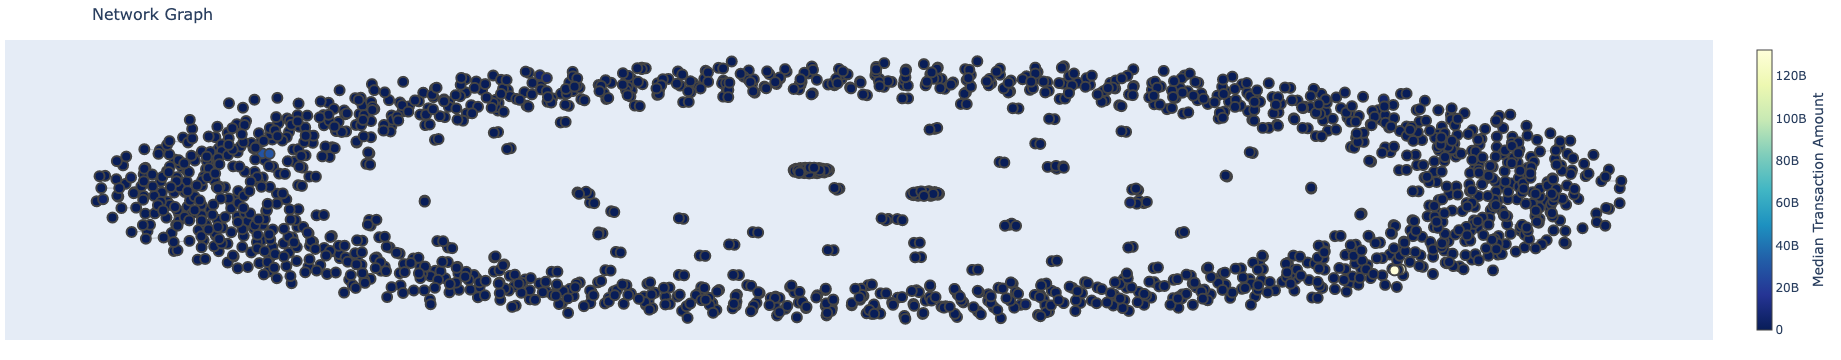

In [97]:
# Create edges in the plotly format
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Create nodes in the plotly format
node_x = []
node_y = []
node_colors = []
node_info = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_colors.append(median_transaction_amounts[node])
    node_info.append(f'{node} - Median Amount: {median_transaction_amounts[node]}')

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    text=node_info,
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=node_colors,
        size=10,
        colorbar=dict(
            thickness=15,
            title='Median Transaction Amount',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Network Graph',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()


### Node degree (sum of in and out degree)

In [209]:
# Create a directed multigraph
G = nx.MultiDiGraph()

# Add nodes and edges
G.add_nodes_from(df["Account"].unique(), type='Account')
G.add_nodes_from(df["Account.1"].unique(), type='Account.1')

for _, row in df.iterrows():
    year = row["Year"]
    month = row["Month"]
    day = row["Day"]
    hour = row["Hour"]
    minute = row["Minute"]
    amount_paid = row["Amount Paid USD"]
    currency_code =  row["Currency Code"]
    payment_format = row["Payment Format"]
 
    G.add_edge(row['Account'], row['Account.1'], year=year, month=month, day=day,
               hour=hour, minute=minute, amount_paid=amount_paid, currency_code=currency_code,
               payment_format=payment_format)


In [105]:
# Compute the median transaction amount per node
transaction_amounts = defaultdict(list)
for node1, node2, edge_data in G.edges(data=True):
    transaction_amounts[node1].append(edge_data['amount_paid'])
    transaction_amounts[node2].append(edge_data['amount_paid'])
median_transaction_amounts = {node: np.median(amounts) for node, amounts in transaction_amounts.items()}


In [106]:
# Get the in-degree, out-degree and degree (total number of transactions) for each node
node_in_degrees = {node: val for node, val in G.in_degree()}
node_out_degrees = {node: val for node, val in G.out_degree()}
node_degrees = {node: val for node, val in G.degree()}


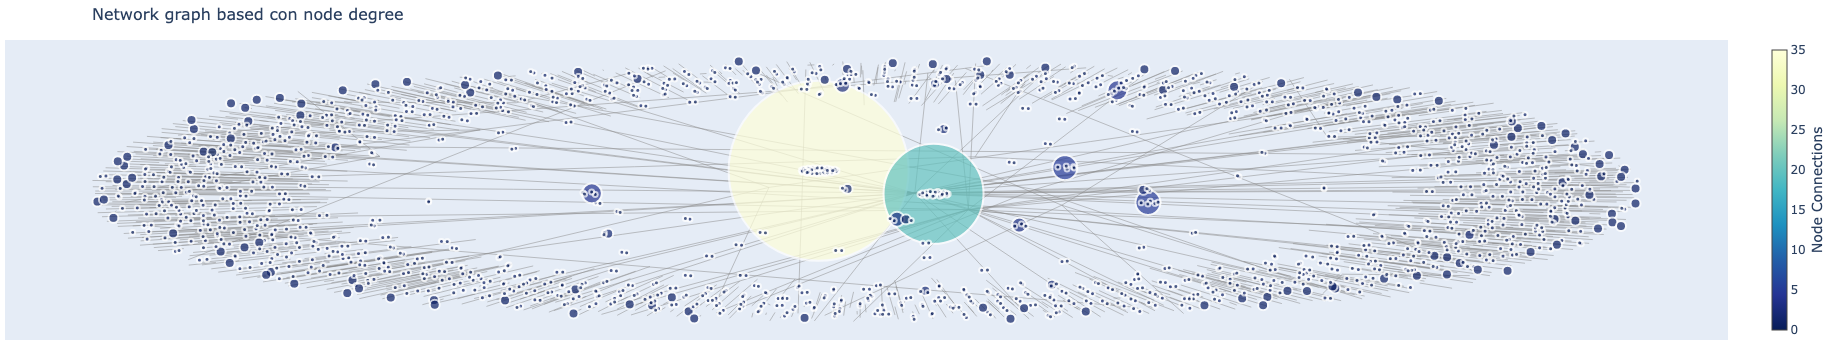

In [109]:
# Get positions for the nodes in G
pos = nx.spring_layout(G)

# Create a plotly figure
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=[],
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('Node: ' + str(adjacencies[0]) + ' - Degree: ' + str(node_degrees[adjacencies[0]]))

node_trace.marker.color = node_adjacencies
node_trace.marker.size = [v * 5 for v in node_degrees.values()] # Multiply degree by 5 to get noticeable size difference
node_trace.text = node_text

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Network graph based con node degree',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()


### Hubs, based on betweenness centrality

Betweenness centrality of a node is a measure of centrality in a graph based on shortest paths. It is equal to the number of shortest paths from all edges to all others that pass through that node. Nodes with higher values can be considered as "hubs".

In [125]:
# calculate betweenness centrality using an approximation method
betweenness_centrality = nx.betweenness_centrality(G, k=500)  # k is the number of sample nodes to use


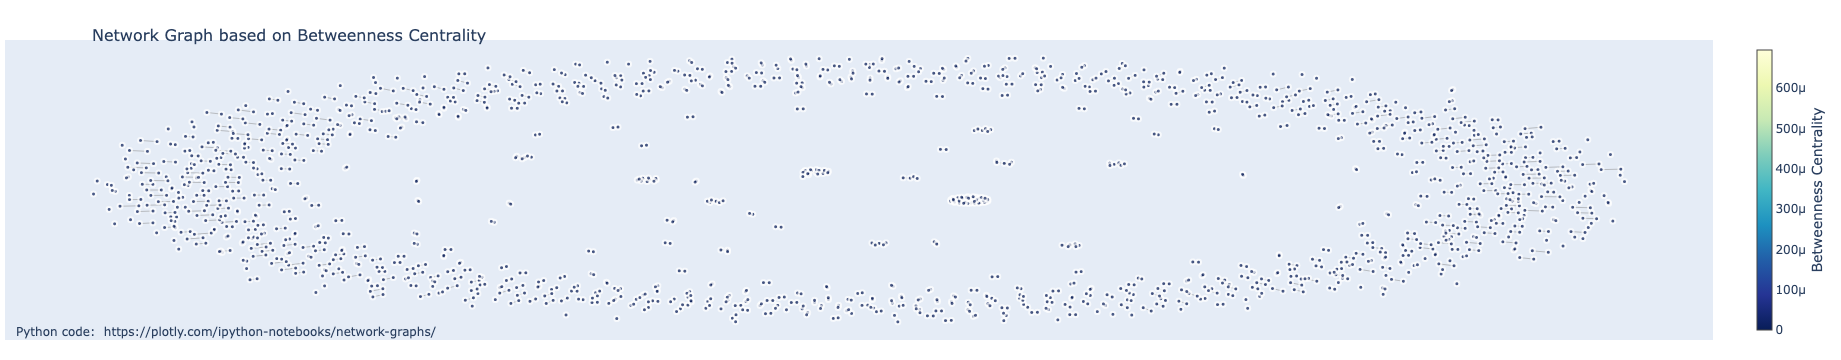

In [129]:
# Position nodes using Fruchterman-Reingold force-directed algorithm
pos = nx.spring_layout(G)

# Initialize edge trace
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Add edges to trace
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

# Initialize node trace
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=[],  # Initialize as empty list
        colorbar=dict(
            thickness=15,
            title='Betweenness Centrality',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

# Add nodes to trace and color nodes by betweenness centrality
for node in G.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['marker']['color'] += tuple([betweenness_centrality[node]])
    node_trace['marker']['size'] += tuple([(betweenness_centrality[node] * 100) + 5])  # Scale size by centrality
    node_trace['text'] += tuple([f'Node {node}: Betweenness Centrality {betweenness_centrality[node]}'])

# Create a figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='<br>Network Graph based on Betweenness Centrality',
                    titlefont=dict(size=16),
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[dict(
                        text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002)],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()

In [203]:
# Compute all simple cycles in the graph
cycles = list(nx.simple_cycles(G))

# Print the cycles
for i, cycle in enumerate(cycles):
    print(f"Cycle {i+1}: {cycle}")


Cycle 1: ['80D880EE0']
Cycle 2: ['80DB8C2F0']
Cycle 3: ['80B1DF8A0']
Cycle 4: ['8038B3910']
Cycle 5: ['8036C8390']
Cycle 6: ['8036E9D70']
Cycle 7: ['80B2C2980']
Cycle 8: ['8021695E0']
Cycle 9: ['80CAE8A90']
Cycle 10: ['80B17A4A0']
Cycle 11: ['80140BA90']
Cycle 12: ['803602280']
Cycle 13: ['800E1D060']
Cycle 14: ['809F579A0']
Cycle 15: ['806DC4400']
Cycle 16: ['800978E90']
Cycle 17: ['8024F0980']
Cycle 18: ['805833660']
Cycle 19: ['8094C5AC0']
Cycle 20: ['813E88D90']
Cycle 21: ['80B691480']
Cycle 22: ['8029EE0E0']
Cycle 23: ['805EF3F30']
Cycle 24: ['803E7E9E0']
Cycle 25: ['801087CE0']
Cycle 26: ['808095420']
Cycle 27: ['801D9B200']
Cycle 28: ['80A887A80']
Cycle 29: ['811F90200']
Cycle 30: ['8007DA0D0']
Cycle 31: ['80D53E030']
Cycle 32: ['80F2642E0']
Cycle 33: ['802A41200']
Cycle 34: ['812B1DB00']
Cycle 35: ['80149C170']
Cycle 36: ['80A3BCD50']
Cycle 37: ['801D3A3C0']
Cycle 38: ['8029AA9C0']
Cycle 39: ['80005F7B0']
Cycle 40: ['800503A70']
Cycle 41: ['8079A8C10']
Cycle 42: ['8069E4980']
C

In [210]:
# Filter the cycles by their length
cycles_of_length_2_or_more = [cycle for cycle in cycles if len(cycle) >= 2]
# Print the cycles
for i, cycle in enumerate(cycles_of_length_2_or_more):
    print(f"Cycle {i+1}: {cycle}")

Cycle 1: ['813B3AE61', '813B3C5A1']


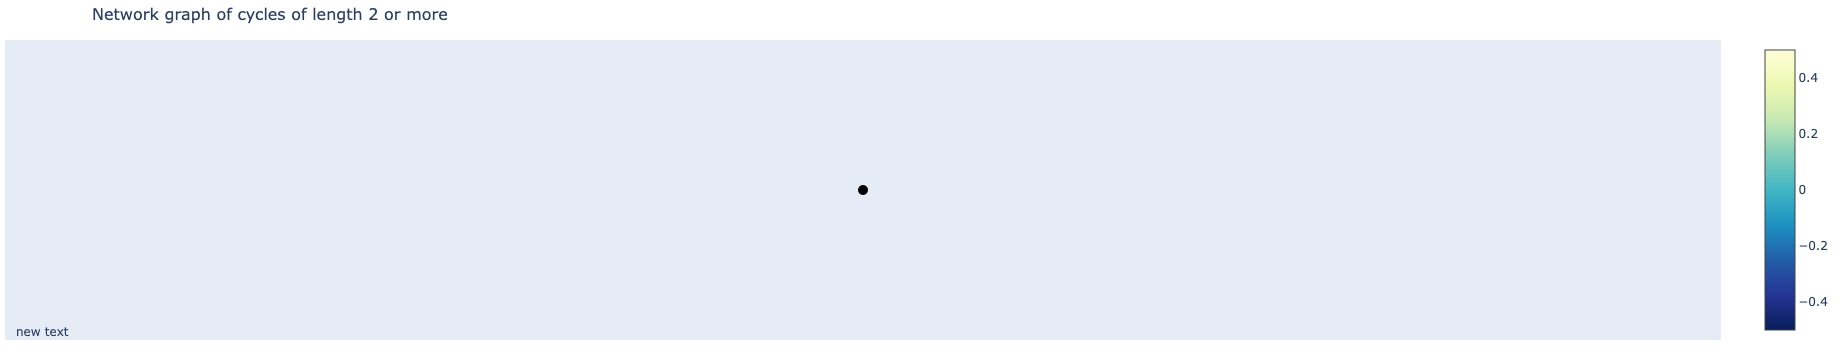

In [211]:
# Flatten the list of cycles and remove duplicates to get the nodes in cycles of length 2 or more
cycle_nodes = list(set([node for cycle in cycles_of_length_2_or_more for node in cycle]))

# Create a new graph G_cycle with only the nodes and edges in cycles of length 2 or more
G_cycle = G.subgraph(cycle_nodes)

# Compute the layout positions for the nodes in G_cycle
pos = nx.spring_layout(G_cycle)

# Create node trace
node_trace = go.Scatter(
    x=[],
    y=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10))

# Add node positions to the node trace
for node in G_cycle.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

# Create edge trace
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Add edge positions to the edge trace
for edge in G_cycle.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

# Create a figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Network graph of cycles of length 2 or more',
                    titlefont=dict(size=16),
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    annotations=[dict(
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002 )],
                    ))

fig.show()